Apunte importante: Este documento es un resumen del proyecto original, el cual conllevó dos meses de experimentación con diversos modelos y técnicas como UMAP, LTR, similitud de coseno y aumento de datos. Dichos métodos no se incluyen en este notebook debido a su falta de relevancia en los resultados finales.

**Primero se genera el dataframe necesario utilizando el archivo de Palomitacas y procediendo con su limpieza.**

In [1]:
import pandas as pd
import utils 

ruta_input = 'data/biblioteca-peliculas-20250905.csv' 
ruta_output = 'biblioteca_pelis_depurada.csv'

df_depurado = utils.limpiar_dataset_inicial(ruta_input, ruta_output)

if df_depurado is not None:
    print("Info del DataFrame resultante:")
    print(df_depurado.info())

C:\Users\gonzalo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Initial load: 407 rows
[INFO] Valid rows: 336
Info del DataFrame resultante:
<class 'pandas.core.frame.DataFrame'>
Index: 336 entries, 0 to 406
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             336 non-null    int64  
 1   id_imdb        336 non-null    object 
 2   titulo         335 non-null    object 
 3   mi_valoracion  336 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 13.1+ KB
None


**Una vez obtenidos los datos, se procede al enriquecimiento mediante la API de OMDB.**

In [ ]:
import pandas as pd
import utils 

ruta_entrada = 'biblioteca_pelis_depurada.csv' 
ruta_salida_enriquecida = 'biblioteca_peliculas_con_detalles.csv'
API_KEY = "xxxxxxx"

if 'df_depurado' not in locals():
    df_depurado = pd.read_csv(ruta_entrada)

df_enriquecido = utils.enriquecer_con_omdb(df_depurado, API_KEY, ruta_salida_enriquecida)

if df_enriquecido is not None:
    print("Primeras filas del resultado combinado:")
    display(df_enriquecido.head())
    
    fallos = df_enriquecido[df_enriquecido['Response'] == 'False']
    print(f"Películas enriquecidas correctamente: {len(df_enriquecido) - len(fallos)}")
    print(f"Películas con error de descarga: {len(fallos)}")


[INFO] Downloading metadata for 336 movies...


OMDB API: 100%|██████████| 336/336 [01:44<00:00,  3.21it/s]

[INFO] Saved to: biblioteca_peliculas_con_detalles.csv
Primeras filas del resultado combinado:


,id,id_imdb,titulo,mi_valoracion,Title,Year,Rated,Released,Runtime,Genre,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
0,335983,tt1270797,Venom,7.0,Venom,2018,PG-13,05 Oct 2018,112 min,"Action, Adventure, Sci-Fi",...,35,6.6,"594,407",tt1270797,movie,N/A,"$213,515,506",N/A,N/A,True
1,331482,tt3281548,Mujercitas,9.0,Little Women,2019,PG,25 Dec 2019,135 min,"Drama, Romance",...,91,7.8,"278,609",tt3281548,movie,N/A,"$108,101,214",N/A,N/A,True
2,508442,tt2948372,Soul,9.0,Soul,2020,PG,25 Dec 2020,100 min,"Animation, Adventure, Comedy",...,83,8.0,"420,335",tt2948372,movie,N/A,"$946,154",N/A,N/A,True
3,75656,tt1670345,Ahora me ves,9.0,Now You See Me,2013,PG-13,31 May 2013,115 min,"Crime, Mystery, Thriller",...,50,7.2,"760,442",tt1670345,movie,N/A,"$117,723,989",N/A,N/A,True
4,291805,tt3110958,Ahora me ves 2,9.0,Now You See Me 2,2016,PG-13,10 Jun 2016,129 min,"Action, Adventure, Comedy",...,46,6.4,"354,869",tt3110958,movie,N/A,"$65,075,540",N/A,N/A,True


Películas enriquecidas correctamente: 336
Películas con error de descarga: 0


In [6]:
import pandas as pd
import utils

ruta_enriquecida = 'biblioteca_peliculas_con_detalles.csv'
df_enriquecido = pd.read_csv(ruta_enriquecida)

df_final_raw = utils.limpieza_post_api(df_enriquecido)

print("Estructura del Dataset limpio:")
print(df_final_raw.info())
display(df_final_raw.head(10))

[INFO] Remaining columns: 19
Estructura del Dataset limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             336 non-null    int64  
 1   id_imdb        336 non-null    object 
 2   mi_valoracion  336 non-null    float64
 3   Rated          323 non-null    object 
 4   Released       336 non-null    object 
 5   Runtime        336 non-null    object 
 6   Genre          336 non-null    object 
 7   Director       336 non-null    object 
 8   Writer         333 non-null    object 
 9   Actors         336 non-null    object 
 10  Plot           336 non-null    object 
 11  Language       336 non-null    object 
 12  Country        336 non-null    object 
 13  Awards         282 non-null    object 
 14  Ratings        336 non-null    object 
 15  Metascore      270 non-null    float64
 16  imdbRating     335 non-null    float64

,id,id_imdb,mi_valoracion,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Ratings,Metascore,imdbRating,imdbVotes,BoxOffice
0,335983,tt1270797,7.0,PG-13,05 Oct 2018,112 min,"Action, Adventure, Sci-Fi",Ruben Fleischer,"Jeff Pinkner, Scott Rosenberg, Kelly Marcel","Tom Hardy, Michelle Williams, Riz Ahmed",After a faulty interview with the Life Foundat...,"English, Mandarin, Malay","United States, China",2 wins & 9 nominations total,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.6,"594,407","$213,515,506"
1,331482,tt3281548,9.0,PG,25 Dec 2019,135 min,"Drama, Romance",Greta Gerwig,"Greta Gerwig, Louisa May Alcott","Saoirse Ronan, Emma Watson, Florence Pugh","In the years after the Civil War, Jo March (Sa...","English, French",United States,Won 1 Oscar. 73 wins & 229 nominations total,"[{'Source': 'Internet Movie Database', 'Value'...",91.0,7.8,"278,609","$108,101,214"
2,508442,tt2948372,9.0,PG,25 Dec 2020,100 min,"Animation, Adventure, Comedy","Pete Docter, Kemp Powers","Pete Docter, Mike Jones, Kemp Powers","Jamie Foxx, Tina Fey, Graham Norton",Joe is a middle-school band teacher whose life...,"English, Korean, Inuktitut",United States,Won 2 Oscars. 124 wins & 91 nominations total,"[{'Source': 'Internet Movie Database', 'Value'...",83.0,8.0,"420,335","$946,154"
3,75656,tt1670345,9.0,PG-13,31 May 2013,115 min,"Crime, Mystery, Thriller",Louis Leterrier,"Ed Solomon, Boaz Yakin, Edward Ricourt","Jesse Eisenberg, Common, Mark Ruffalo",Four magicians each answer a mysterious summon...,"English, French","United States, France",1 win & 3 nominations total,"[{'Source': 'Internet Movie Database', 'Value'...",50.0,7.2,"760,442","$117,723,989"
4,291805,tt3110958,9.0,PG-13,10 Jun 2016,129 min,"Action, Adventure, Comedy",Jon M. Chu,"Ed Solomon, Peter Chiarelli, Boaz Yakin","Jesse Eisenberg, Mark Ruffalo, Woody Harrelson",One year after outwitting the F.B.I. and winni...,"English, Mandarin, Cantonese","United States, Hong Kong",5 nominations total,"[{'Source': 'Internet Movie Database', 'Value'...",46.0,6.4,"354,869","$65,075,540"
5,342470,tt3907584,6.5,TV-MA,28 Feb 2020,107 min,"Drama, Romance",Brett Haley,"Jennifer Niven, Liz Hannah","Elle Fanning, Justice Smith, Alexandra Shipp","The story of Violet Markey and Theodore Finch,...",English,United States,1 win total,"[{'Source': 'Internet Movie Database', 'Value'...",61.0,6.6,"42,771",NaN
6,505600,tt1489887,7.5,R,24 May 2019,102 min,Comedy,Olivia Wilde,"Emily Halpern, Sarah Haskins, Susanna Fogel","Kaitlyn Dever, Beanie Feldstein, Jessica Williams","On the eve of their high school graduation, tw...","English, Mandarin, French, Spanish",United States,Nominated for 1 BAFTA Award29 wins & 60 nomina...,"[{'Source': 'Internet Movie Database', 'Value'...",84.0,7.1,"138,077","$22,680,962"
7,391713,tt4925292,7.5,R,01 Dec 2017,94 min,"Comedy, Drama",Greta Gerwig,Greta Gerwig,"Saoirse Ronan, Laurie Metcalf, Tracy Letts","Christine ""Lady Bird"" McPherson (Saoirse Ronan...","English, Spanish",United States,Nominated for 5 Oscars. 124 wins & 228 nominat...,"[{'Source': 'Internet Movie Database', 'Value'...",93.0,7.4,"359,235","$48,958,273"
8,694234,tt10941528,7.0,TV-MA,01 Jul 2020,101 min,"Comedy, Drama, Romance",Younuts,"Caterina Salvadori, Enrico Vanzina, Ciro Zecca","Cristiano Caccamo, Davide Calgaro, Matteo Osca...","On holiday at Riccione beach, a group of teens...",Italian,Italy,NaN,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,5.6,"3,393",NaN
9,778730,tt11698630,8.0,TV-MA,26 Feb 2021,102 min,"Comedy, Romance",Dani de la Orden,"Natalia Durán, Eric Navarro","Álvaro Cervantes, Susana Abaitua, Luis Zahera","After a magical night together, Adri voluntari...",Spanish,Spain,NaN,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.6,"6,827",NaN


In [7]:
import pandas as pd
import utils 

ruta_entrada = 'biblioteca_peliculas_con_detalles.csv'
ruta_salida_limpia = 'biblioteca_peliculas_limpia.csv'

df = pd.read_csv(ruta_entrada)
print(f"Dimensiones antes de limpiar: {df.shape}")

# Pipeline de Limpieza
df = utils.limpiar_features_numericas(df)
df = utils.extraer_awards(df)
df = utils.extraer_rotten_tomatoes(df)
df_final = utils.seleccionar_columnas_finales(df)

df_final.to_csv(ruta_salida_limpia, index=False)

print(f"Dimensiones después de limpiar: {df_final.shape}")
print("Tipos de datos resultantes:")
print(df_final.dtypes)

print("Vista previa de las nuevas features generadas:")
display(df_final[['Title', 'Awards_Oscars', 'Awards_Wins', 'RottenTomatoes', 'BoxOffice']].head() 
        if 'Title' in df_final.columns else df_final.head())

Dimensiones antes de limpiar: (336, 29)
Dimensiones después de limpiar: (336, 20)
Tipos de datos resultantes:
id                      int64
id_imdb                object
mi_valoracion         float64
Year_Released           int32
Runtime                 int64
Genre                  object
Director               object
Writer                 object
Actors                 object
Plot                   object
Language               object
Country                object
Metascore             float64
imdbRating            float64
imdbVotes               int64
BoxOffice             float64
RottenTomatoes        float64
Awards_Oscars           int64
Awards_Wins             int64
Awards_Nominations      int64
dtype: object
Vista previa de las nuevas features generadas:


,id,id_imdb,mi_valoracion,Year_Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Metascore,imdbRating,imdbVotes,BoxOffice,RottenTomatoes,Awards_Oscars,Awards_Wins,Awards_Nominations
0,335983,tt1270797,7.0,2018,112,"Action, Adventure, Sci-Fi",Ruben Fleischer,"Jeff Pinkner, Scott Rosenberg, Kelly Marcel","Tom Hardy, Michelle Williams, Riz Ahmed",After a faulty interview with the Life Foundat...,"English, Mandarin, Malay","United States, China",35.0,6.6,594407,213515506.0,31.0,0,2,9
1,331482,tt3281548,9.0,2019,135,"Drama, Romance",Greta Gerwig,"Greta Gerwig, Louisa May Alcott","Saoirse Ronan, Emma Watson, Florence Pugh","In the years after the Civil War, Jo March (Sa...","English, French",United States,91.0,7.8,278609,108101214.0,95.0,1,73,229
2,508442,tt2948372,9.0,2020,100,"Animation, Adventure, Comedy","Pete Docter, Kemp Powers","Pete Docter, Mike Jones, Kemp Powers","Jamie Foxx, Tina Fey, Graham Norton",Joe is a middle-school band teacher whose life...,"English, Korean, Inuktitut",United States,83.0,8.0,420335,946154.0,95.0,2,124,91
3,75656,tt1670345,9.0,2013,115,"Crime, Mystery, Thriller",Louis Leterrier,"Ed Solomon, Boaz Yakin, Edward Ricourt","Jesse Eisenberg, Common, Mark Ruffalo",Four magicians each answer a mysterious summon...,"English, French","United States, France",50.0,7.2,760442,117723989.0,51.0,0,1,3
4,291805,tt3110958,9.0,2016,129,"Action, Adventure, Comedy",Jon M. Chu,"Ed Solomon, Peter Chiarelli, Boaz Yakin","Jesse Eisenberg, Mark Ruffalo, Woody Harrelson",One year after outwitting the F.B.I. and winni...,"English, Mandarin, Cantonese","United States, Hong Kong",46.0,6.4,354869,65075540.0,34.0,0,0,5


**Se divide el dataset en diversos subconjuntos de características similares (ej. escritores, directores) para evaluar su aporte informativo individual.**


In [8]:
import pandas as pd
import utils 

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']

cols_num = [
    'Runtime', 'BoxOffice', 'Awards_Oscars', 'Awards_Wins', 'Awards_Nominations',
    'RottenTomatoes', 'Metascore', 'imdbRating', 'imdbVotes', 'Year_Released'
]
X_num = df[[c for c in cols_num if c in df.columns]]

res_num = utils.evaluar_subset(X_num, y, "Numérico")
display(res_num)


Evaluating Subset: Numérico (10 features)


Models Numérico: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


,Subset,Modelo,R2,MSE,MAE
0,Numérico,Lasso (L1),0.044184,0.644645,0.590614
1,Numérico,Ridge (L2),0.047998,0.642106,0.599561
2,Numérico,RandomForest,-0.055056,0.709093,0.647400
3,Numérico,CatBoost,-0.083134,0.728990,0.652144
4,Numérico,SVR,0.036271,0.649067,0.594400
5,Numérico,AVERAGE,-0.001948,0.674780,0.616823


**Se observa un R2 positivo en regresiones lineales, lo cual indica presencia de señal, aunque sea reducida.**

In [9]:
import pandas as pd
import utils 

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']

X_genre = utils.preparar_multi_hot(df, 'Genre', min_freq=0.01)
res_genre = utils.evaluar_subset(X_genre, y, "Género")
display(res_genre)


Evaluating Subset: Género (17 features)


Models Género:   0%|          | 0/5 [00:00<?, ?it/s]

Models Género: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


,Subset,Modelo,R2,MSE,MAE
0,Género,Lasso (L1),-0.023180,0.689062,0.599063
1,Género,Ridge (L2),-0.126248,0.755809,0.645916
2,Género,RandomForest,-0.134251,0.757453,0.655924
3,Género,CatBoost,-0.186310,0.795852,0.669054
4,Género,SVR,-0.054717,0.709943,0.628559
5,Género,AVERAGE,-0.104941,0.741624,0.639703


In [10]:
import pandas as pd
import utils 

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']

X_director = utils.preparar_multi_hot(df, 'Director', min_freq=0.01)
res_director = utils.evaluar_subset(X_director, y, "Director")
display(res_director)


Evaluating Subset: Director (2 features)


Models Director: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


,Subset,Modelo,R2,MSE,MAE
0,Director,Lasso (L1),-0.025090,0.690181,0.599098
1,Director,Ridge (L2),-0.030000,0.694288,0.604482
2,Director,RandomForest,-0.030978,0.694664,0.604116
3,Director,CatBoost,-0.030037,0.694317,0.604503
4,Director,SVR,-0.031294,0.696350,0.611838
5,Director,AVERAGE,-0.029480,0.693960,0.604807


In [11]:
import pandas as pd
import utils 

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']

X_writer = utils.preparar_multi_hot(df, 'Writer', min_freq=0.01)
res_writer = utils.evaluar_subset(X_writer, y, "Writer")
display(res_writer)


Evaluating Subset: Writer (8 features)


Models Writer: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


,Subset,Modelo,R2,MSE,MAE
0,Writer,Lasso (L1),-0.024378,0.689733,0.598782
1,Writer,Ridge (L2),-0.020259,0.685940,0.602556
2,Writer,RandomForest,-0.008986,0.678469,0.599362
3,Writer,CatBoost,-0.019662,0.685571,0.602495
4,Writer,SVR,-0.004751,0.676475,0.599810
5,Writer,AVERAGE,-0.015607,0.683237,0.600601


In [12]:
import pandas as pd
import utils 

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']

X_actors = utils.preparar_multi_hot(df, 'Actors', min_freq=0.01)
res_actors = utils.evaluar_subset(X_actors, y, "Actors")
display(res_actors)


Evaluating Subset: Actors (33 features)


Models Actors: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


,Subset,Modelo,R2,MSE,MAE
0,Actors,Lasso (L1),-0.012758,0.681937,0.601621
1,Actors,Ridge (L2),-0.074712,0.722891,0.639987
2,Actors,RandomForest,-0.077376,0.720652,0.633582
3,Actors,CatBoost,-0.095425,0.733730,0.643171
4,Actors,SVR,-0.074314,0.722650,0.635297
5,Actors,AVERAGE,-0.066917,0.716372,0.630731


In [13]:
import pandas as pd
import utils 

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']

X_lang = utils.preparar_multi_hot(df, 'Language', min_freq=0.01)
res_lang = utils.evaluar_subset(X_lang, y, "Language")
display(res_lang)


Evaluating Subset: Language (16 features)


Models Language: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


,Subset,Modelo,R2,MSE,MAE
0,Language,Lasso (L1),-0.023120,0.688849,0.599392
1,Language,Ridge (L2),-0.083687,0.731827,0.633759
2,Language,RandomForest,-0.079302,0.729517,0.653504
3,Language,CatBoost,-0.140844,0.772362,0.671997
4,Language,SVR,-0.055581,0.714368,0.630549
5,Language,AVERAGE,-0.076507,0.727385,0.637840


In [14]:
import pandas as pd
import utils 

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']

X_country = utils.preparar_multi_hot(df, 'Country', min_freq=0.01)
res_country = utils.evaluar_subset(X_country, y, "Country")
display(res_country)


Evaluating Subset: Country (16 features)


Models Country: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


,Subset,Modelo,R2,MSE,MAE
0,Country,Lasso (L1),-0.026130,0.690992,0.599352
1,Country,Ridge (L2),-0.102342,0.741997,0.627654
2,Country,RandomForest,-0.086634,0.729517,0.619884
3,Country,CatBoost,-0.140565,0.763949,0.642703
4,Country,SVR,-0.026972,0.690873,0.606163
5,Country,AVERAGE,-0.076529,0.723466,0.619151


**Los experimentos iniciales sugieren que la predicción es compleja y los predictores individuales presentan un rendimiento muy limitado**

**Ante la problemática de la dimensionalidad, vamos a implementar un enfoque basado en Target Encoding.**

In [15]:
import pandas as pd
import utils

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']

res_genre = utils.evaluar_subset_global_target(df, y, 'Genre')
display(res_genre)


Evaluating Genre (Global Target Encoding)


Models Genre:   0%|          | 0/5 [00:00<?, ?it/s]

Models Genre: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


,Subset,Modelo,R2,MSE,MAE
0,Genre,Lasso,-0.025090,0.690181,0.599098
1,Genre,Ridge,-0.066529,0.718282,0.615684
2,Genre,RF,-0.166941,0.785634,0.664448
3,Genre,CatB,-0.191628,0.799412,0.669161
4,Genre,SVR,-0.096533,0.736862,0.639849
5,Genre,AVERAGE,-0.109344,0.746074,0.637648


In [16]:
res_director = utils.evaluar_subset_global_target(df, y, 'Director')
display(res_director)


Evaluating Director (Global Target Encoding)


Models Director: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


,Subset,Modelo,R2,MSE,MAE
0,Director,Lasso,-0.086033,0.729359,0.641359
1,Director,Ridge,-0.123614,0.754445,0.654760
2,Director,RF,-0.160725,0.777708,0.646154
3,Director,CatB,-0.186400,0.794420,0.650121
4,Director,SVR,-0.153821,0.773553,0.656673
5,Director,AVERAGE,-0.142119,0.765897,0.649814


In [17]:
res_writer = utils.evaluar_subset_global_target(df, y, 'Writer')
display(res_writer)


Evaluating Writer (Global Target Encoding)


Models Writer: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


,Subset,Modelo,R2,MSE,MAE
0,Writer,Lasso,-0.027289,0.691601,0.598795
1,Writer,Ridge,-0.060682,0.711135,0.603757
2,Writer,RF,-0.070558,0.717943,0.629284
3,Writer,CatB,-0.111908,0.742993,0.638418
4,Writer,SVR,-0.039358,0.691740,0.636089
5,Writer,AVERAGE,-0.061959,0.711082,0.621269


In [18]:
res_actors = utils.evaluar_subset_global_target(df, y, 'Actors')
display(res_actors)


Evaluating Actors (Global Target Encoding)


Models Actors: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


,Subset,Modelo,R2,MSE,MAE
0,Actors,Lasso,-0.069665,0.719549,0.621650
1,Actors,Ridge,-0.066343,0.717208,0.624886
2,Actors,RF,-0.090500,0.731636,0.614588
3,Actors,CatB,-0.067962,0.716929,0.608572
4,Actors,SVR,-0.069283,0.717790,0.615207
5,Actors,AVERAGE,-0.072751,0.720622,0.616981


In [19]:
res_lang = utils.evaluar_subset_global_target(df, y, 'Language')
display(res_lang)


Evaluating Language (Global Target Encoding)


Models Language: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


,Subset,Modelo,R2,MSE,MAE
0,Language,Lasso,-0.017987,0.685413,0.597686
1,Language,Ridge,-0.024460,0.690883,0.618291
2,Language,RF,-0.096104,0.744269,0.658810
3,Language,CatB,-0.106061,0.750668,0.661243
4,Language,SVR,-0.025254,0.691109,0.614503
5,Language,AVERAGE,-0.053974,0.712468,0.630107


In [20]:
res_country = utils.evaluar_subset_global_target(df, y, 'Country')
display(res_country)


Evaluating Country (Global Target Encoding)


Models Country: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


,Subset,Modelo,R2,MSE,MAE
0,Country,Lasso,-0.037464,0.698353,0.599602
1,Country,Ridge,-0.070694,0.719981,0.606733
2,Country,RF,-0.079695,0.726430,0.621395
3,Country,CatB,-0.118121,0.754996,0.638629
4,Country,SVR,-0.037305,0.698706,0.605891
5,Country,AVERAGE,-0.068656,0.719693,0.614450


**Los resultados individuales de Target Encoding muestran un R2 bajo, posiblemente debido a la limitada cantidad de características por subconjunto. Se procederá a realizar una comparativa masiva entre Multi-Hot y Target Encoding utilizando modelos lineales con regularización L1 y L2, evaluando la estabilidad mediante múltiples semillas.**

Debemos formalizar la siguiente métrica que llamaremos métrica combinada, la cual de forma simplificada será (ver codigo para entenderla completa):

μR 
2
 /(0.5⋅(σR 
2
 ⋅σMSE)⋅μMSE)

Esta métrica penaliza la inestabilidad y el error, priorizando modelos con alto R2 y baja varianza.
Esta métrica, al ser algo extraña e ir de -∞ a +∞, es poco intuitiva, por lo que será siempre mostrada junto a otras más comunes como R2, MSE, MAE y Correlación de Pearson.


In [8]:
import pandas as pd
import numpy as np
import utils 

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']

cols_num = [
    'Runtime', 'BoxOffice', 'Awards_Oscars', 'Awards_Wins', 'Awards_Nominations',
    'RottenTomatoes', 'Metascore', 'imdbRating', 'imdbVotes', 'Year_Released'
]
cat_cols = ['Genre', 'Director', 'Writer', 'Actors', 'Language', 'Country']

X_base = df[cols_num + cat_cols].copy()
X_base[cols_num] = X_base[cols_num].fillna(-1)

res_comparativa = utils.comparativa_final_encoding(X_base, y, cat_cols, seeds=np.arange(1, 26, 1))

summary = res_comparativa.groupby(['Encoding', 'Modelo']).agg({
    'R2': ['mean', 'std'],
    'MSE': ['mean', 'std'],
    'MAE': 'mean',
    'Corr': 'mean'
})

summary.columns = ['_'.join(col).strip() for col in summary.columns.values]

summary['Combined_Metric'] = summary.apply(
    lambda row: utils.calcular_metrica_cine(
        row['R2_mean'], row['MSE_mean'], row['R2_std'], row['MSE_std']
    ), axis=1
)

cols_show = ['Combined_Metric', 'R2_mean', 'R2_std', 'MSE_mean', 'MSE_std', 'MAE_mean', 'Corr_mean']
print("Resumen Final: Multi-Hot vs Global Target Encoding")
resumen_formateado = summary[cols_show].sort_values(by='Combined_Metric', ascending=False)

display(resumen_formateado.style.format({
    'Combined_Metric': lambda x: '{:.2f}'.format(x) if abs(x) < 1000 else '{:.2e}'.format(x),
    'R2_mean': '{:.4f}',
    'R2_std': '{:.4f}',
    'MSE_mean': '{:.4f}',
    'MSE_std': '{:.4f}',
    'MAE_mean': '{:.4f}',
    'Corr_mean': '{:.4f}'
}))

[INFO] Encoding Comparison (25 seeds)


Processing Seeds: 100%|██████████| 25/25 [06:21<00:00, 15.26s/it]

Resumen Final: Multi-Hot vs Global Target Encoding


**Target Encoding demuestra una superioridad notable frente a Multi-Hot Encoding, presentando un mayor R2, menor MSE y mejores metricas en general.**

**Análisis del argumento (Plot): Se generan embeddings de 768 dimensiones y se evalúa su capacidad predictiva mediante reducción de dimensionalidad y algoritmos KNN.**

In [22]:
import pandas as pd
import utils

df = pd.read_csv('biblioteca_peliculas_limpia.csv')

df_embeddings = utils.generar_embeddings_plot(df)

ruta_completa = 'biblioteca_numerica_completa.csv'
df_full = utils.guardar_dataset_completo(df, df_embeddings, ruta_completa)

print(f"Dimensiones finales: {df_full.shape}")
display(df_full[[c for c in df_full.columns if 'plot_' in c]].head(3))

14:59:10 - [utils] - Use pytorch device_name: cpu


14:59:10 - [utils] - Load pretrained SentenceTransformer: all-mpnet-base-v2



[NLP] Loading model: all-mpnet-base-v2...
[NLP] Generating embeddings for 336 plots...


Batches: 100%|██████████| 11/11 [00:52<00:00,  4.80s/it]


[INFO] Full dataset saved: biblioteca_numerica_completa.csv
Dimensiones finales: (336, 788)


,plot_0,plot_1,plot_2,plot_3,plot_4,plot_5,plot_6,plot_7,plot_8,plot_9,...,plot_758,plot_759,plot_760,plot_761,plot_762,plot_763,plot_764,plot_765,plot_766,plot_767
0,0.040228,-0.006968,0.019217,0.010069,0.010069,0.022423,-0.061148,-0.020465,0.014367,0.054787,...,0.024078,-0.030605,0.077488,-0.015386,0.004848,-0.087868,0.042833,0.011277,-0.012130,-0.014321
1,0.005759,0.059065,-0.015761,-0.016515,0.045078,0.031474,-0.019262,-0.002106,0.045846,0.023429,...,-0.014918,0.012599,0.002096,-0.042788,-0.020398,-0.049702,-0.005846,0.061969,-0.005062,-0.003923
2,0.024636,0.057851,-0.010395,0.035161,0.027012,0.005220,-0.079768,-0.019313,-0.125988,0.049882,...,-0.003716,0.020072,-0.044516,0.005289,-0.029878,-0.039170,-0.001853,0.029770,0.061588,-0.027290


[INFO] Computing PCA...
[INFO] Computing UMAP...


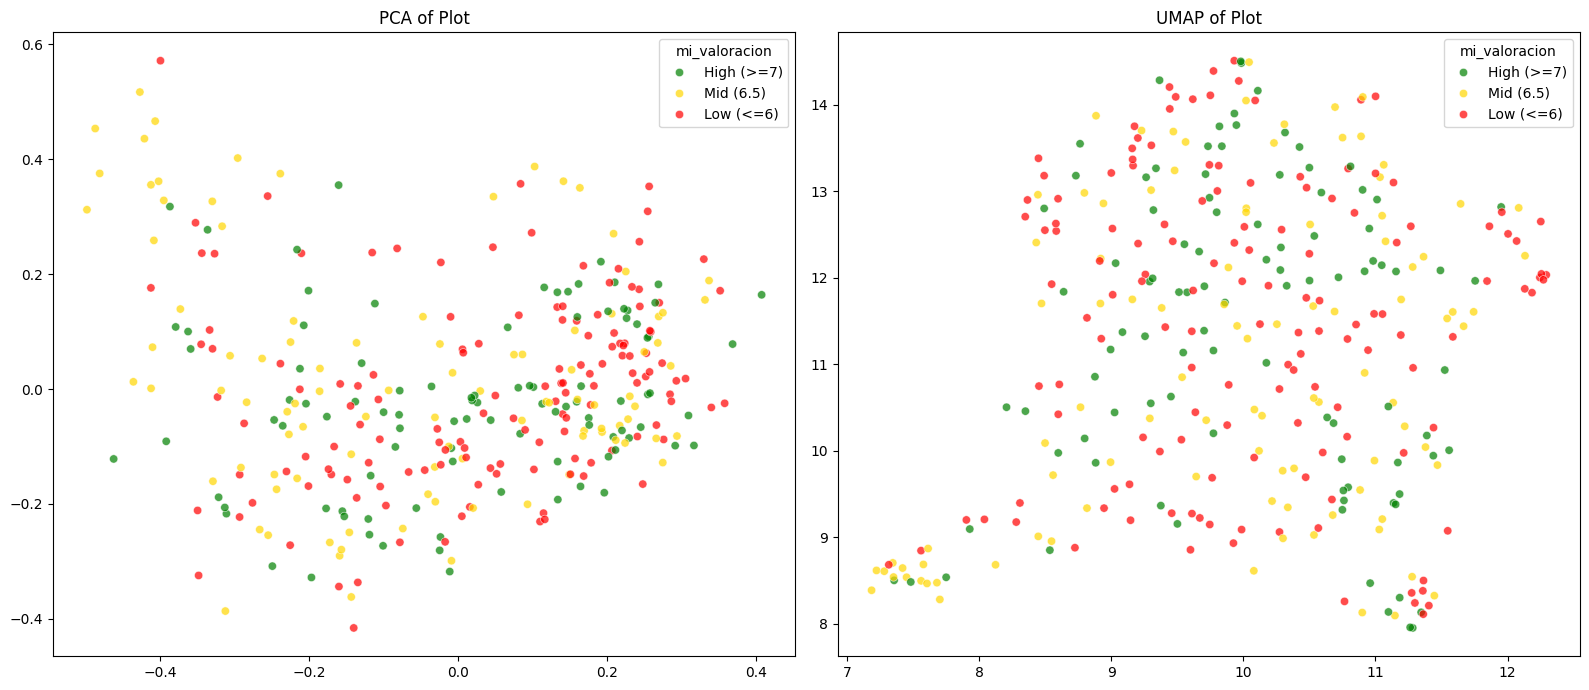

In [23]:
import pandas as pd
import utils 

df_full = pd.read_csv('biblioteca_numerica_completa.csv')
y = df_full['mi_valoracion']
plot_cols = [c for c in df_full.columns if c.startswith('plot_')]
X_plot = df_full[plot_cols]

utils.visualizar_plot_2d(X_plot, y)

**La visualización no revela clusters definidos por valoración. La reducción de 768 a 2 dimensiones conlleva una pérdida semántica significativa, dificultando la separación.**

In [4]:
import pandas as pd
import numpy as np
import utils 

df_full = pd.read_csv('biblioteca_numerica_completa.csv')
y = df_full['mi_valoracion']

plot_cols = [c for c in df_full.columns if c.startswith('plot_')]
X_plot = df_full[plot_cols]

print(f"Features de Plot: {X_plot.shape[1]}")

res_knn = utils.evaluar_knn_plot_robusto(X_plot, y, seeds=np.arange(100, 125, 1))

summary = res_knn.groupby('Metric').agg({
    'R2': ['mean', 'std'],
    'MSE': ['mean', 'std'],
    'MAE': ['mean', 'std'],
    'Corr': ['mean', 'std'],
    'Best_K': 'mean'
})

summary.columns = ['_'.join(col).strip() for col in summary.columns.values]

summary['Combined_Metric'] = summary.apply(
    lambda row: utils.calcular_metrica_cine(
        row['R2_mean'], row['MSE_mean'], row['R2_std'], row['MSE_std']
    ), axis=1
)

print("Resultados KNN (Plot)")
display(summary.sort_values('Combined_Metric', ascending=False))

Features de Plot: 768

[INFO] Starting Robust KNN (25 seeds)


KNN Seeds: 100%|██████████| 25/25 [01:25<00:00,  3.42s/it]

Resultados KNN (Plot)


,R2_mean,R2_std,MSE_mean,MSE_std,MAE_mean,MAE_std,Corr_mean,Corr_std,Best_K_mean,Combined_Metric
Metric,,,,,,,,,,
Cosine (L2),-0.024349,0.047048,0.699323,0.121658,0.615041,0.050865,0.079117,0.106734,64.68,-12.16608
Euclidean,-0.024349,0.047048,0.699323,0.121658,0.615041,0.050865,0.079117,0.106734,64.68,-12.16608


**Los resultados de KNN sobre el Plot son deficientes, con R2 negativos y baja correlación. Se procede a evaluar si la reducción de ruido mediante PCA mejora el rendimiento.**

In [5]:
import pandas as pd
import numpy as np
import utils 

df_full = pd.read_csv('biblioteca_numerica_completa.csv')
y = df_full['mi_valoracion']
plot_cols = [c for c in df_full.columns if c.startswith('plot_')]
X_plot = df_full[plot_cols]

res_pca = utils.evaluar_pca_knn_robusto(X_plot, y, seeds=np.arange(200, 225, 1))

summary = res_pca.groupby('Metric').agg({
    'R2': ['mean', 'std'],
    'MSE': ['mean', 'std'],
    'MAE': ['mean', 'std'],
    'Corr': ['mean', 'std'],
    'Real_Dims': 'mean',
    'Best_K': 'mean'
})
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]

summary['Combined_Metric'] = summary.apply(
    lambda row: utils.calcular_metrica_cine(
        row['R2_mean'], row['MSE_mean'], row['R2_std'], row['MSE_std']
    ), axis=1
)

print("Resultados PCA + KNN (Plot)")
display(summary.sort_values('Combined_Metric', ascending=False))


[INFO] Starting Robust PCA+KNN (25 seeds)


PCA+KNN Seeds: 100%|██████████| 25/25 [04:12<00:00, 10.09s/it]

Resultados PCA + KNN (Plot)


,R2_mean,R2_std,MSE_mean,MSE_std,MAE_mean,MAE_std,Corr_mean,Corr_std,Real_Dims_mean,Best_K_mean,Combined_Metric
Metric,,,,,,,,,,,
Cosine (L2),-0.04423,0.077685,0.694563,0.125685,0.619746,0.058367,0.09822,0.126382,39.8,16.6,-13.044226
Euclidean,-0.04423,0.077685,0.694563,0.125685,0.619746,0.058367,0.09822,0.126382,39.8,16.6,-13.044226


**La combinación de PCA y KNN tampoco arroja resultados satisfactorios; el modelo tiende a predecir la media, lo que confirma la baja utilidad predictiva del Plot en este contexto.**

Ante la ausencia de predictores con una capacidad explicativa robusta en las etapas anteriores, se optó por incorporar una dimensión social al modelo para mitigar las carencias de señal. **Se solicitó a diversos usuarios de la plataforma su colaboración mediante la cesión de sus registros de valoración, a lo cual accedieron voluntariamente, tratándose en todo caso de información que ya poseía carácter público.**

**El objetivo de esta integración es permitir que el modelo identifique cómo interactúa mi criterio personal con el de otros perfiles**, buscando patrones de afinidad o discrepancia. De este modo, se complementan las métricas puramente objetivas (como las puntuaciones de IMDb o el palmarés de los Oscars) con datos subjetivos provenientes de usuarios con hábitos de consumo similares, aportando una capa de información relacional que los metadatos técnicos no pueden capturar por sí solos.

**Nota: El uso de estos datos implica una limitación temporal; películas posteriores a mediados de 2025 carecerán de estas métricas, afectando la precisión. Con el tiempo deberemos ejecutar el pipeline otra vez para actualizar el modelo.**

In [26]:
import pandas as pd
import utils 

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']

ruta_usuarios_real = 'data'
df_con_usuarios, cols_users = utils.cargar_datos_usuarios_recursivo(ruta_usuarios_real, df)

if len(cols_users) > 0:
    print(f"Ejemplo de usuarios: {cols_users[:5]}")
    X_users = df_con_usuarios[cols_users]
    res_users = utils.evaluar_subset(X_users, y, "Usuarios (Friends)")
    display(res_users)
else:
    print("No se encontraron usuarios. Revisa la ruta.")


[INFO] Loading users from 'data'...
[INFO] Integrated 179 users.
Ejemplo de usuarios: ['user_AdrianStark', 'user_airin', 'user_AlbertoCS', 'user_AlfRamone69', 'user_Algu']

Evaluating Subset: Usuarios (Friends) (179 features)


Models Usuarios (Friends): 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


,Subset,Modelo,R2,MSE,MAE
0,Usuarios (Friends),Lasso (L1),0.071133,0.625610,0.593340
1,Usuarios (Friends),Ridge (L2),-2.416117,2.320478,1.135255
2,Usuarios (Friends),RandomForest,0.053097,0.637505,0.608437
3,Usuarios (Friends),CatBoost,0.042895,0.640194,0.596562
4,Usuarios (Friends),SVR,0.021905,0.657075,0.599558
5,Usuarios (Friends),AVERAGE,-0.445417,0.976172,0.706630


**Optimización de arquitectura mediante búsqueda bayesiana (Optuna). Se evalúan combinaciones de los 8 subconjuntos disponibles utilizando modelos lineales con regularización (L1 y L2).**

In [10]:
import pandas as pd
import utils 
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']
df_users, cols_users = utils.cargar_datos_usuarios_recursivo('data', df)

X_dict = {}
cols_num = ['Runtime', 'BoxOffice', 'Awards_Oscars', 'Awards_Wins', 'Awards_Nominations', 'RottenTomatoes', 'Metascore', 'imdbRating', 'imdbVotes', 'Year_Released']
X_dict['NUM'] = df[cols_num].fillna(-1)
X_dict['USERS'] = df_users[cols_users]
for cat in ['Genre', 'Director', 'Writer', 'Actors', 'Language', 'Country']:
    X_dict[cat] = df[[cat]]

df_optuna_unicos = utils.optimizar_arquitectura_unica(
    X_dict, 
    y, 
    n_trials=100, #100
    n_seeds_inner=25 #25
)

cols_show = [
    'Trial', 'Metric_Comb', 
    'R2_Mean', 'R2_Std', 
    'MSE_Mean', 'MSE_Std', 
    'MAE_Mean', 'Corr_Mean', 
    'Model', 'Avg_Alpha', 'Smooth', 
    'Use_Num', 'Use_Users', 'Cats_Active'
]

print("Top 10 Arquitecturas")
display(df_optuna_unicos[cols_show].head(10))

print("Bottom 10 Arquitecturas")
display(df_optuna_unicos[cols_show].tail(10))


[INFO] Loading users from 'data'...
[INFO] Integrated 179 users.

[OPTUNA] Optimization (100 Trials x 25 Seeds)


Trials: 100%|██████████| 100/100 [1:58:28<00:00, 71.09s/it]  

[INFO] Results saved to: resultados_optuna_unicos.csv
Top 10 Arquitecturas


,Trial,Metric_Comb,R2_Mean,R2_Std,MSE_Mean,MSE_Std,MAE_Mean,Corr_Mean,Model,Avg_Alpha,Smooth,Use_Num,Use_Users,Cats_Active
32,49,34.808639,0.078650,0.054169,0.622302,0.134057,0.593378,0.324893,Lasso,0.088200,4,True,True,Genre+Language
86,220,34.797338,0.078641,0.054180,0.622308,0.134056,0.593435,0.324865,Lasso,0.087987,5,True,True,Genre+Language
51,93,34.756619,0.078866,0.054383,0.622164,0.134125,0.593351,0.325170,Lasso,0.087987,3,True,True,Genre
52,96,34.731308,0.079011,0.054521,0.622066,0.134151,0.593302,0.325267,Lasso,0.087743,4,True,True,Genre
84,208,34.719886,0.079003,0.054533,0.622071,0.134151,0.593304,0.325255,Lasso,0.087743,5,True,True,Genre
47,86,34.666657,0.079015,0.054567,0.622090,0.134289,0.593387,0.325213,Lasso,0.087706,2,True,True,Genre
33,50,34.530791,0.078326,0.054224,0.622575,0.134383,0.593394,0.324458,Lasso,0.088035,3,True,True,Genre+Language
50,91,34.515607,0.078860,0.054663,0.622198,0.134355,0.593352,0.325154,Lasso,0.087482,1,True,True,Genre
80,189,34.455995,0.079005,0.054991,0.622023,0.134066,0.593686,0.324218,Lasso,0.086437,5,True,True,Language
76,171,34.452395,0.079003,0.054996,0.622024,0.134066,0.593632,0.324231,Lasso,0.086650,4,True,True,Language


Bottom 10 Arquitecturas


,Trial,Metric_Comb,R2_Mean,R2_Std,MSE_Mean,MSE_Std,MAE_Mean,Corr_Mean,Model,Avg_Alpha,Smooth,Use_Num,Use_Users,Cats_Active
75,169,-22.025190,-0.131700,0.109668,0.758688,0.143732,0.644870,0.117946,Lasso,0.055293,3,True,True,Director+Language
67,146,-22.368011,-0.136647,0.111992,0.761637,0.143241,0.645014,0.116928,Lasso,0.051638,2,False,True,Genre+Director
83,200,-22.950597,-0.135709,0.109181,0.761027,0.142330,0.644763,0.116745,Lasso,0.053247,2,True,True,Director+Language
5,5,-23.515019,-0.142453,0.112353,0.764915,0.140980,0.643904,0.114680,Lasso,0.048233,1,False,True,Genre+Director+Language
97,262,-23.835417,-0.141464,0.110620,0.764272,0.140401,0.643723,0.114396,Lasso,0.049849,1,True,True,Director
37,59,-24.441943,-0.143336,0.107414,0.766143,0.142521,0.649544,0.119988,Lasso,0.031262,3,True,False,Director+Language+Country
1,1,-24.458794,-0.144854,0.108783,0.766958,0.141968,0.651469,0.118057,Lasso,0.013176,5,False,False,Director+Language
36,56,-24.524521,-0.146871,0.110178,0.768061,0.141539,0.649484,0.117688,Lasso,0.031610,2,True,False,Genre+Director+Language
19,19,-24.606541,-0.150115,0.112549,0.769808,0.140824,0.647122,0.116411,Lasso,0.030458,1,True,False,Director+Language
24,24,-26.555259,-0.153042,0.108486,0.771418,0.137728,0.647506,0.113469,Lasso,0.019956,1,False,False,Director+Writer


**Se extiende la optimización a modelos de Random Forest para capturar relaciones no lineales y mejorar la robustez frente al sobreajuste.**

In [13]:
import pandas as pd
import utils 
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']
df_users, cols_users = utils.cargar_datos_usuarios_recursivo('data', df)

X_dict = {}
X_dict['NUM'] = df[['Runtime', 'BoxOffice', 'Year_Released', 'imdbVotes', 'RottenTomatoes']].fillna(-1)
X_dict['USERS'] = df_users[cols_users]
for cat in ['Genre', 'Director', 'Writer', 'Actors', 'Language', 'Country']:
    X_dict[cat] = df[[cat]]

df_optuna_rf = utils.optimizar_arquitectura_unica_rf(
    X_dict, 
    y, 
    n_trials=200, #200
    n_seeds_inner=25 #25
)

cols_show = ['Trial', 'Metric_Comb', 'R2_Mean', 'R2_Std', 'MSE_Mean', 'MSE_Std', 'MAE_Mean', 'Corr_Mean', 'Params_RF', 'Smooth', 'Use_Num', 'Use_Users', 'Cats_Active']

print("Top 10 Arquitecturas (Random Forest)")
display(df_optuna_rf[cols_show].head(10))

print("Bottom 10 Arquitecturas (Random Forest)")
display(df_optuna_rf[cols_show].tail(10))


[INFO] Loading users from 'data'...
[INFO] Integrated 179 users.

[OPTUNA] Architecture + RF (200 Trials)


Trials RF: 100%|██████████| 200/200 [32:35<00:00,  9.78s/it]

Top 10 Arquitecturas (Random Forest)


,Trial,Metric_Comb,R2_Mean,R2_Std,MSE_Mean,MSE_Std,MAE_Mean,Corr_Mean,Params_RF,Smooth,Use_Num,Use_Users,Cats_Active
79,139,35.830096,0.073020,0.043199,0.631594,0.149388,0.595164,0.323387,"{'n': 213, 'd': 3}",5,False,True,Director+Writer+Country
121,249,35.225358,0.072981,0.043943,0.631580,0.149300,0.595340,0.323202,"{'n': 214, 'd': 3}",3,False,True,Director+Writer+Country
123,252,35.048028,0.075405,0.045813,0.629815,0.149131,0.595870,0.321194,"{'n': 216, 'd': 3}",3,False,True,Writer+Language+Country
83,151,34.947929,0.072028,0.043560,0.632278,0.149661,0.595169,0.321304,"{'n': 192, 'd': 3}",5,False,True,Director+Writer+Country
132,269,34.508039,0.075427,0.046740,0.629630,0.148545,0.595764,0.321866,"{'n': 159, 'd': 3}",3,False,True,Writer+Language+Country
86,160,34.226429,0.078180,0.049309,0.627511,0.147644,0.595066,0.323863,"{'n': 172, 'd': 5}",4,False,True,Director+Writer+Country
85,159,33.587323,0.071127,0.044403,0.633062,0.150670,0.596076,0.319351,"{'n': 172, 'd': 3}",4,False,True,Director+Writer+Country
110,218,33.229893,0.067761,0.043248,0.634793,0.148552,0.596031,0.312360,"{'n': 216, 'd': 4}",5,False,True,Director+Writer+Language+Country
143,295,33.099218,0.071457,0.045601,0.632591,0.149680,0.595196,0.310161,"{'n': 126, 'd': 3}",3,False,True,Director+Writer+Country
139,286,33.088148,0.073268,0.047172,0.631046,0.148773,0.596288,0.316455,"{'n': 132, 'd': 3}",3,False,True,Writer+Language+Country


Bottom 10 Arquitecturas (Random Forest)


,Trial,Metric_Comb,R2_Mean,R2_Std,MSE_Mean,MSE_Std,MAE_Mean,Corr_Mean,Params_RF,Smooth,Use_Num,Use_Users,Cats_Active
16,16,-21.232580,-0.069834,0.056629,0.725437,0.160124,0.622865,0.052825,"{'n': 251, 'd': 8}",4,True,True,Writer+Actors
49,49,-21.480772,-0.078083,0.060807,0.731274,0.163492,0.622771,0.033671,"{'n': 117, 'd': 18}",3,True,False,Genre+Actors
23,23,-21.557298,-0.173631,0.123809,0.791632,0.164356,0.659092,0.086602,"{'n': 78, 'd': 15}",2,True,True,Director+Language+Country
13,13,-21.746239,-0.182137,0.127214,0.797454,0.165121,0.657290,0.085083,"{'n': 152, 'd': 6}",4,True,False,Director+Language+Country
24,24,-21.980787,-0.065168,0.052265,0.721954,0.157144,0.623153,0.050135,"{'n': 137, 'd': 12}",5,False,True,Genre+Director+Writer+Actors
5,5,-22.126763,-0.190829,0.131735,0.802463,0.163166,0.660100,0.083478,"{'n': 80, 'd': 9}",2,True,False,Director+Language+Country
28,28,-22.695628,-0.078102,0.058554,0.730930,0.160810,0.621104,0.032459,"{'n': 297, 'd': 13}",2,False,False,Genre+Actors+Country
27,27,-22.881272,-0.071494,0.054710,0.726030,0.157324,0.621250,0.029530,"{'n': 117, 'd': 9}",2,False,False,Director+Actors+Language
31,31,-23.504817,-0.072107,0.052571,0.727138,0.160502,0.623689,0.053821,"{'n': 91, 'd': 17}",1,True,True,Genre+Writer+Actors+Language+Country
34,34,-25.135561,-0.290599,0.131853,0.874132,0.200617,0.683161,-0.018355,"{'n': 281, 'd': 15}",4,False,False,Genre+Country


**El modelo Random Forest presenta un rendimiento superior (R2 ~0.11, MSE < 0.6). Se observa que las valoraciones de usuarios y la variable 'Writer' son recurrentes en las mejores configuraciones.**

In [1]:
import pandas as pd
import utils 
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

df = pd.read_csv('biblioteca_peliculas_limpia.csv')
y = df['mi_valoracion']
df_users, cols_users = utils.cargar_datos_usuarios_recursivo('data', df)

X_dict = {}
X_dict['NUM'] = df[['Runtime', 'BoxOffice', 'Year_Released', 'imdbVotes', 'RottenTomatoes']].fillna(0)
X_dict['USERS'] = df_users[cols_users]
for cat in ['Genre', 'Director', 'Writer', 'Actors', 'Language', 'Country']:
    X_dict[cat] = df[[cat]]

df_ag_optuna = utils.optimizar_arquitectura_autogluon(
    X_dict, 
    y, 
    n_trials=25, #25
    n_seeds=10, #10
    time_limit=120
)

print("Mejores Arquitecturas (AutoGluon)")
display(df_ag_optuna)

C:\Users\gonzalo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[INFO] Loading users from 'data'...
[INFO] Integrated 179 users.

[AUTOGLUON] Optimization (25 Trials, 120s/seed)


Trials AG: 100%|██████████| 25/25 [1:52:39<00:00, 270.37s/it]

[INFO] AutoGluon results saved: resultados_optuna_ag.csv
Mejores Arquitecturas (AutoGluon)


,Trial,Metric_Comb,R2_Mean,R2_Std,MSE_Mean,MSE_Std,MAE_Mean,Corr_Mean,Use_Num,Use_Users,Cats_Active
7,7,8.620313,0.025806,0.071233,0.692586,0.121361,0.613778,0.255690,False,True,Genre+Director+Actors
12,28,4.036791,0.019638,0.099851,0.698364,0.139525,0.624000,0.251487,False,True,Genre+Actors+Language+Country
2,2,3.032533,0.007205,0.051128,0.706900,0.131483,0.625537,0.214528,False,True,Genre+Director
13,29,2.659880,0.011120,0.089493,0.703605,0.132785,0.620872,0.241307,False,True,Genre+Actors+Language
19,46,1.987449,0.007127,0.074803,0.707578,0.135496,0.625417,0.213306,True,True,Genre+Director+Actors
22,65,0.066415,0.000304,0.076853,0.716332,0.166251,0.633963,0.215274,True,True,Genre+Director+Country
18,44,-0.825830,-0.002718,0.073255,0.712701,0.126063,0.626163,0.245402,False,True,Genre+Director+Actors+Country
21,59,-1.376145,-0.007152,0.095462,0.718321,0.151579,0.624522,0.226428,True,True,Genre+Director+Actors+Country
20,57,-2.176298,-0.009463,0.089287,0.717733,0.135698,0.621668,0.227624,False,True,Director+Actors+Country
1,1,-2.426557,-0.009080,0.074619,0.719278,0.139432,0.630949,0.205715,False,True,Genre+Language+Country


**Entrenamiento final: Tras la comparativa, se selecciona la arquitectura ganadora para el entrenamiento definitivo usando la metrica y features encontradas, incluyendo análisis de interpretabilidad mediante SHAP.**

In [14]:
import ast
import pandas as pd

ganadores = []

for archivo, tipo in [('resultados_optuna_unicos.csv', 'Lineal'), 
                     ('resultados_optuna_rf.csv', 'RandomForest'), 
                     ('resultados_optuna_ag.csv', 'AutoGluon')]:
    try:
        df_res = pd.read_csv(archivo)
        mejor = df_res.iloc[0].to_dict()
        mejor['Tipo_Estudio'] = tipo
        ganadores.append(mejor)
    except:
        print(f"No se encontró {archivo}")

df_ganadores = pd.DataFrame(ganadores).sort_values('Metric_Comb', ascending=False)
ganador_absoluto = df_ganadores.iloc[0]

print(f"Ganador Absoluto: {ganador_absoluto['Tipo_Estudio']}")
print(f"Métrica: {ganador_absoluto['Metric_Comb']:.2f} | R2: {ganador_absoluto['R2_Mean']:.4f}")
print(f"Configuración: {ganador_absoluto['Cats_Active']}")

Ganador Absoluto: RandomForest
Métrica: 35.83 | R2: 0.0730
Configuración: Director+Writer+Country


Iniciando Entrenamiento Maestro: RandomForest
Mejores parámetros: {'n_estimators': 337, 'max_depth': 3, 'min_samples_split': 7, 'max_features': 'sqrt'} | Smoothing: 4.0
Métricas Finales (CV 5-Folds)
R2: 0.0774 | MSE: 0.6319


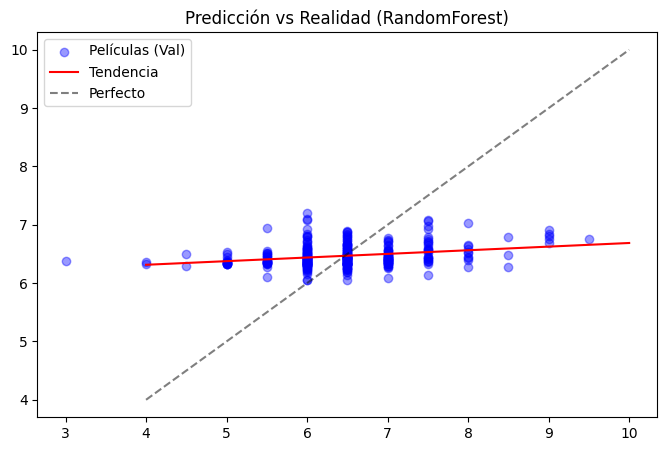

Generando SHAP...


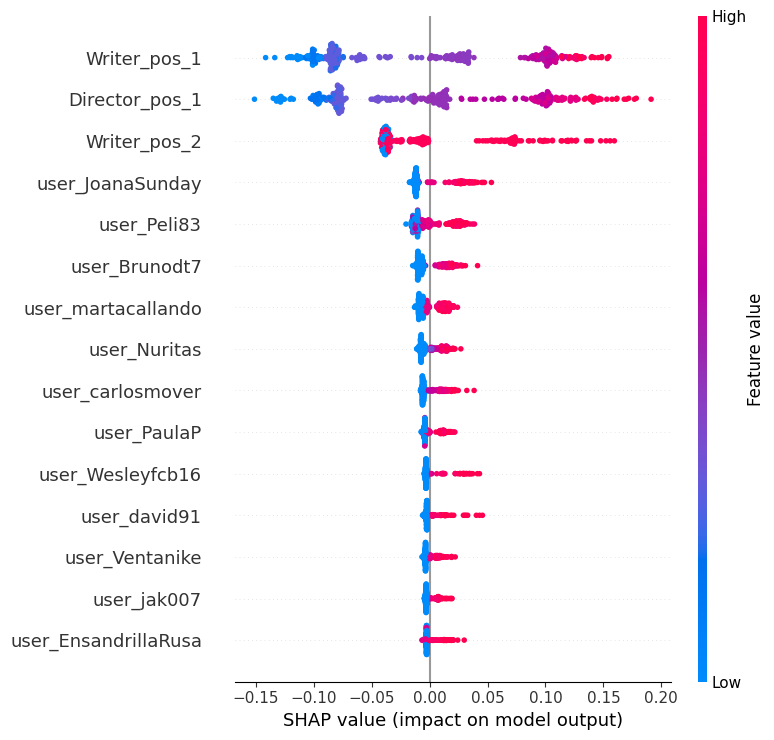

SHAP Local (Nota: 5.0)


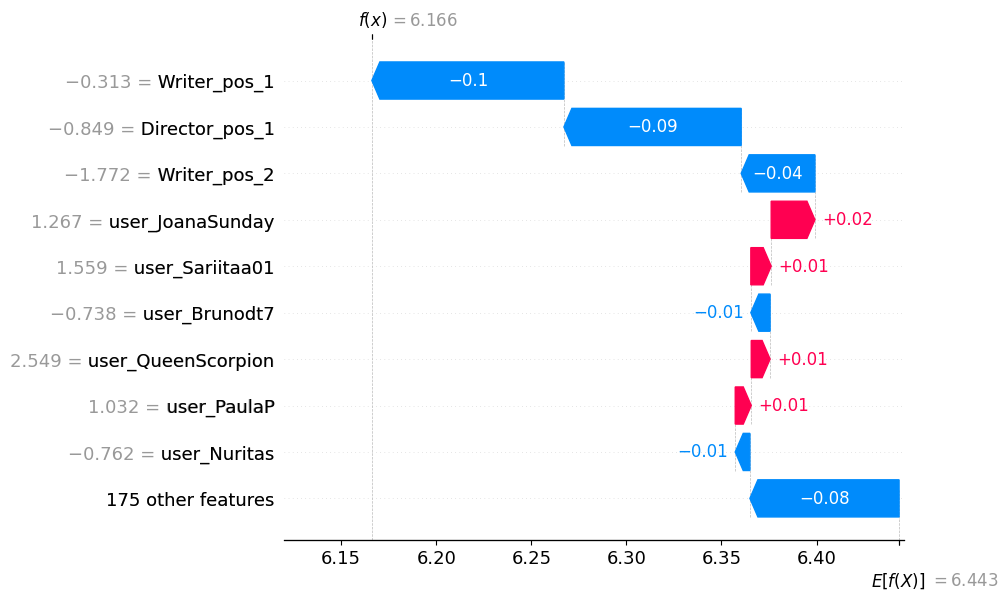

SHAP Local (Nota: 6.5)


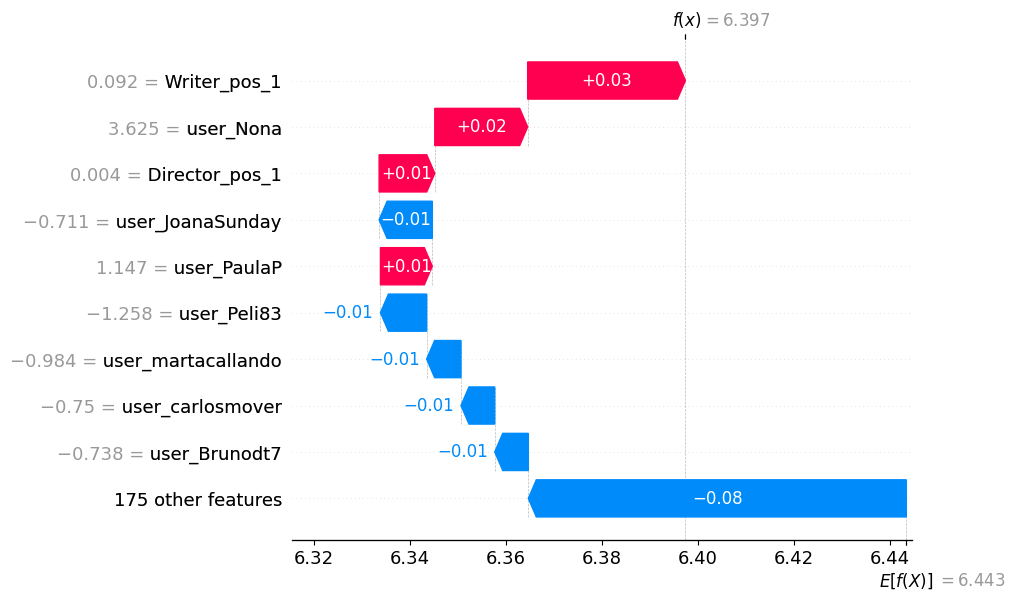

SHAP Local (Nota: 8.0)


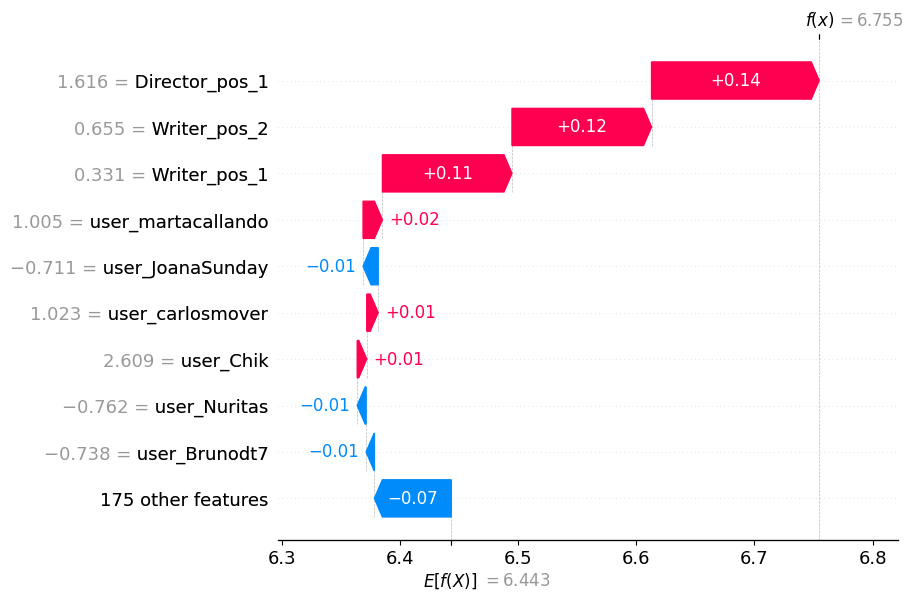

Modelo RandomForest guardado.


In [17]:
import os
import optuna
import shap
import joblib
import ast
import shutil
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import BayesianRidge, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Configuración Dinámica
tipo_modelo = ganador_absoluto['Tipo_Estudio']
cats_activos = ganador_absoluto['Cats_Active'].split('+') if ganador_absoluto['Cats_Active'] != 'None' else []
use_num = ganador_absoluto['Use_Num']
use_users = ganador_absoluto['Use_Users']

parts = []
if use_num: parts.append(X_dict['NUM'])
if use_users: parts.append(X_dict['USERS'])
for cat in cats_activos: parts.append(X_dict[cat])
X_final = pd.concat(parts, axis=1)

print(f"Iniciando Entrenamiento Maestro: {tipo_modelo}")

# CASO A: AutoGluon
if tipo_modelo == 'AutoGluon':
    from autogluon.tabular import TabularPredictor
    smoothing_ag = float(ganador_absoluto.get('Smooth', 3))
    
    X_encoded = X_final.copy()
    for cat in cats_activos:
        enc = utils.PositionalMultiLabelEncoder(col_name=cat, smoothing=smoothing_ag)
        X_encoded = enc.fit_transform(X_encoded, y)
    
    X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    train_data = X_train.copy(); train_data['target'] = y_train
    
    path_ag = 'modelo_final_autogluon'
    if os.path.exists(path_ag): shutil.rmtree(path_ag)
    
    print("Entrenando AutoGluon...")
    predictor = TabularPredictor(label='target', path=path_ag, verbosity=0).fit(
        train_data, presets='medium_quality'
    )
    
    y_pred_val = predictor.predict(X_val)
    print(f"Métricas Validación")
    print(f"R2: {r2_score(y_val, y_pred_val):.4f} | MSE: {mean_squared_error(y_val, y_pred_val):.4f} | MAE: {mean_absolute_error(y_val, y_pred_val):.4f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(y_val, y_pred_val, alpha=0.5, color='green', label='Películas (Val)')
    br = BayesianRidge().fit(np.array(y_val).reshape(-1, 1), y_pred_val)
    plt.plot(np.linspace(4, 10, 100), br.predict(np.linspace(4, 10, 100).reshape(-1, 1)), color='red', label='Tendencia')
    plt.plot([4, 10], [4, 10], 'k--', alpha=0.5, label='Perfecto')
    plt.title("AutoGluon: Predicción vs Realidad"); plt.legend(); plt.show()

    print("Generando SHAP...")
    logging.getLogger().setLevel(logging.WARNING)
    background = shap.sample(X_train, 50) 
    pred_func = lambda x: predictor.predict(pd.DataFrame(x, columns=X_encoded.columns))
    explainer = shap.KernelExplainer(pred_func, background)
    shap_values_global = explainer.shap_values(X_val.iloc[:50])
    plt.figure(); shap.summary_plot(shap_values_global, X_val.iloc[:50], feature_names=X_encoded.columns, max_display=15, show=False); plt.show()

    for nota_obj in [5.0, 6.5, 8.0]:
        target_idx = (y - nota_obj).abs().idxmin()
        row_encoded = X_encoded.loc[[target_idx]]
        print(f"SHAP Local (Nota: {y.loc[target_idx]})")
        shap_val_local = explainer.shap_values(row_encoded)
        exp = shap.Explanation(values=shap_val_local[0], base_values=explainer.expected_value, data=row_encoded.values[0], feature_names=X_encoded.columns.tolist())
        plt.figure(); shap.plots.waterfall(exp, show=True)

    logging.getLogger().setLevel(logging.INFO)
    joblib.dump({'tipo': 'AutoGluon', 'path': path_ag}, 'modelo_cine_final.pkl')

# CASO B: SKLEARN (RF/Lineal)
else:
    def objective(trial):
        current_smoothing = trial.suggest_int('smoothing', 1, 5)
        
        if tipo_modelo == 'RandomForest':
            model = RandomForestRegressor(
                n_estimators=trial.suggest_int('n_estimators', 100, 500),
                max_depth=trial.suggest_int('max_depth', 3, 15),
                min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
                max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', 1.0]),
                random_state=42, n_jobs=-1
            )
        else:
            alpha = trial.suggest_float('alpha', 1e-3, 100, log=True)
            model = Lasso(alpha=alpha) if ganador_absoluto['Model'] == 'Lasso' else Ridge(alpha=alpha)

        transformers = [(f'enc_{c}', utils.PositionalMultiLabelEncoder(col_name=c, smoothing=float(current_smoothing)), [c]) for c in cats_activos]
        pipe = Pipeline([
            ('pre', ColumnTransformer(transformers=transformers, remainder='passthrough')),
            ('imp', SimpleImputer(strategy='median' if tipo_modelo == 'RandomForest' else 'constant')),
            ('scl', StandardScaler()),
            ('model', model)
        ])
        return cross_val_score(pipe, X_final, y, cv=5, scoring='neg_mean_squared_error').mean()

    sampler = optuna.samplers.TPESampler(n_startup_trials=25, seed=42)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(objective, n_trials=50)
    
    best_params = study.best_params
    best_smoothing = float(best_params.pop('smoothing'))
    print(f"Mejores parámetros: {best_params} | Smoothing: {best_smoothing}")

    transformers = [(f'enc_{c}', utils.PositionalMultiLabelEncoder(col_name=c, smoothing=best_smoothing), [c]) for c in cats_activos]
    final_pipe = Pipeline([
        ('pre', ColumnTransformer(transformers=transformers, remainder='passthrough')),
        ('imp', SimpleImputer(strategy='median' if tipo_modelo == 'RandomForest' else 'constant')),
        ('scl', StandardScaler()),
        ('model', RandomForestRegressor(**best_params, random_state=42) if tipo_modelo == 'RandomForest' else Lasso(**best_params))
    ])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_real_all, y_pred_all = [], []
    for train_idx, test_idx in kf.split(X_final, y):
        final_pipe.fit(X_final.iloc[train_idx], y.iloc[train_idx])
        preds = final_pipe.predict(X_final.iloc[test_idx])
        y_real_all.extend(y.iloc[test_idx]); y_pred_all.extend(preds)

    print(f"Métricas Finales (CV 5-Folds)")
    print(f"R2: {r2_score(y_real_all, y_pred_all):.4f} | MSE: {mean_squared_error(y_real_all, y_pred_all):.4f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(y_real_all, y_pred_all, alpha=0.4, color='blue', label='Películas (Val)')
    br = BayesianRidge().fit(np.array(y_real_all).reshape(-1, 1), y_pred_all)
    plt.plot(np.linspace(4, 10, 100), br.predict(np.linspace(4, 10, 100).reshape(-1, 1)), color='red', label='Tendencia')
    plt.plot([4, 10], [4, 10], 'k--', alpha=0.5, label='Perfecto')
    plt.title(f"Predicción vs Realidad ({tipo_modelo})"); plt.legend(); plt.show()

    final_pipe.fit(X_final, y)
    joblib.dump(final_pipe, 'modelo_cine_final.pkl')

    print("Generando SHAP...")
    X_transformed = final_pipe.named_steps['pre'].transform(X_final)
    X_transformed = final_pipe.named_steps['imp'].transform(X_transformed)
    X_transformed = final_pipe.named_steps['scl'].transform(X_transformed)

    feature_names = []
    preprocessor = final_pipe.named_steps['pre']
    cols_categoricas = []
    for name, transformer, cols in preprocessor.transformers_:
        if name != 'remainder':
            k = transformer.k_
            feature_names.extend([f"{cols[0]}_pos_{i+1}" for i in range(k)])
            cols_categoricas.extend(cols)
    feature_names.extend([c for c in X_final.columns if c not in cols_categoricas])

    modelo_final = final_pipe.named_steps['model']
    explainer = shap.TreeExplainer(modelo_final) if tipo_modelo == 'RandomForest' else shap.LinearExplainer(modelo_final, X_transformed)
    shap_values = explainer.shap_values(X_transformed)

    plt.figure(); shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, max_display=15, show=False); plt.show()

    for nota_obj in [5.0, 6.5, 8.0]:
        target_idx = (y - nota_obj).abs().idxmin()
        int_pos = y.index.get_loc(target_idx)
        print(f"SHAP Local (Nota: {y.loc[target_idx]})")
        base_val = explainer.expected_value
        if isinstance(base_val, (np.ndarray, list)): base_val = base_val[0]
        plt.figure()
        shap_exp = shap.Explanation(values=shap_values[int_pos], base_values=base_val, data=X_transformed[int_pos], feature_names=feature_names)
        shap.plots.waterfall(shap_exp, show=True)

    print(f"Modelo {tipo_modelo} guardado.")

**Despliegue e Inferencia: Implementación del predictor final que integra la API de OMDB y la base de datos social.**

In [ ]:
import utils 

API_KEY = "xxxxxxx"
RUTA_USUARIOS = 'data' 
MODELO_PATH = 'modelo_cine_final.pkl'

predictor = utils.CinePredictor(
    model_path=MODELO_PATH, 
    users_path=RUTA_USUARIOS, 
    api_key=API_KEY
)

peli = "tt16311594" # F1: The Movie (2025)
resultado = predictor.predecir(peli)

if isinstance(resultado, dict):
    print(f"Película: {resultado['Title']}")
    print(f"Vista por: {resultado['Friends_Watched']} amigos")
    print(f"NOTA PREDICHA: {resultado['Prediction']} / 10")
else:
    print(resultado)

[INFO] CinePredictor: Loaded Sklearn model (RandomForestRegressor).
[INFO] Indexing user database from 'data'...

[QUERY] Searching for: 'tt16311594'
[MATCH] F1: The Movie (tt16311594)
[SOCIAL] 33 friends watched this.
Película: F1: The Movie
Vista por: 33 amigos
NOTA PREDICHA: 6.52 / 10


**Conclusiones:**

Este proyecto finaliza con la implementación de un pipeline completo para la predicción de valoraciones cinematográficas. A pesar de enfrentarnos a un dataset caracterizado por una alta subjetividad y una cantidad limitada de muestras, se ha logrado extraer señal predictiva y consolidar modelos estables. Si bien las métricas obtenidas reflejan la complejidad de modelar gustos personales, la estructura del proyecto garantiza su escalabilidad: ante un incremento en el volumen de películas vistas, el sistema permite una actualización automatizada de los modelos mediante la reejecución del flujo de limpieza y entrenamiento. Ante todo se reconoce la dificultad de obtener unas buenas métricas en este dominio.

**Mejoras futuras:**

Análisis individualizado: Implementar un sistema de segmentación por usuario similar al aplicado en las valoraciones propias, utilizando técnicas de Target Encoding para capturar sesgos específicos de cada perfil social.

Refinamiento de variables: Investigar métodos avanzados de feature pruning para eliminar ruido redundante y mejorar la eficiencia computacional del modelo.

Meta-learning y Transfer Learning: Explorar el entrenamiento previo en datasets de terceros con perfiles de gusto similares para transferir los pesos hacia el modelo personal, compensando así la falta de datos iniciales.

Optimización mediante transformaciones matemáticas: Evaluar el impacto de transformar las variables de entrada o el target mediante funciones específicas como f(x)=asinh(x−b)+c, q(x)=kx+l o w(x)=r⋅tanh(ix−t)+u. El uso de estas funciones permitiría un mapeo no lineal del espacio de características; por ejemplo, la aplicación de w(x) (basada en la tangente hiperbólica) resultaría clave para controlar y expandir la desviación estándar en rangos críticos de la escala. Esto ayudaría al algoritmo a diferenciar con mayor precisión entre valoraciones muy cercanas, optimizando potencialmente las métricas de R2 y reduciendo el MSE al alinear mejor la distribución de los datos con las capacidades del modelo.